In [ ]:
!pip install torch==1.12.1

In [1]:
!pip install fastai

     -------------------------------------- 232.8/232.8 kB 1.0 MB/s eta 0:00:00
     ---------------------------------------- 67.6/67.6 kB 3.8 MB/s eta 0:00:00
  Using cached matplotlib-3.5.3-cp37-cp37m-win_amd64.whl (7.2 MB)

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rich 12.6.0 requires typing-extensions<5.0,>=4.0.0; python_version < "3.9", but you have typing-extensions 3.10.0.2 which is incompatible.
parlai 1.5.1 requires importlib-metadata<4.3, but you have importlib-metadata 4.11.3 which is incompatible.
parlai 1.5.1 requires myst-parser~=0.12.2, but you have myst-parser 0.18.1 which is incompatible.
parlai 1.5.1 requires Sphinx~=2.2.0, but you have sphinx 5.3.0 which is incompatible.
parlai 1.5.1 requires tqdm~=4.62.1, but you have tqdm 4.64.1 which is incompatible.
flake8 4.0.1 requires importlib-metadata<4.3; python_version < "3.8", but you have importlib-metadata 4.11.3 which is incompatible.
aiohttp 3.7.4.post0 requires async-timeout<4.0,>=3.0, but you have async-timeout 4.0.2 which is incompatible.

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] 


  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.0


In [1]:
import os
import sys
import numpy as np
import pandas as pd

from timm import create_model
import fastai
from fastai.vision.all import *
import timm
set_seed(999, reproducible=True)

In [2]:
dataset_path_train = './'

dataset_path_test = './'

In [3]:
avail_pretrained_models= timm.list_models(pretrained=True)
avail_pretrained_models

['adv_inception_v3',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'cspdarknet53',
 'cspresnet50',
 'cspresnext50',
 'deit_base_distilled_patch16_224',
 'deit_base_distilled_patch16_384',
 'deit_base_patch16_224',
 'deit_base_patch16_384',
 'deit_small_distilled_patch16_224',
 'deit_small_patch16_224',
 'deit_tiny_distilled_patch16_224',
 'deit_tiny_patch16_224',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2next',
 'dla60x',
 'dla60x_c',
 'dla102',
 'dla102x',
 'dla102x2',
 'dla169',
 'dm_nfnet_f0',
 'dm_nfnet_f1',
 'dm_nfnet_f2',
 'dm_nfnet_f3',
 'dm_nfnet_f4',
 'dm_nfnet_f5',
 'dm_nfnet_f6',
 'dpn68',
 'dpn

In [4]:
# model names in timm, corresponding image input sizes and weights in the final model blend

# TIMM_MODELS = (('vit_large_patch14_clip_224.openai_ft_in1k', 384, 1.0), ('swin_large_patch4_window12_384', 384, 0.168), ('vit_large_patch14_clip_336', 336, 0.063), 
            #    ('beit_large_patch16_384', 384, 0.261), ('beitv2_large_patch16_224', 224, 0.087), ('beit_large_patch16_224.in22k_ft_in22k', 224, 0.232))
TIMM_MODELS = ('efficientnet_b4', 736, 1.0)

In [5]:
train_df = pd.read_csv(dataset_path_train + 'train.csv')
train_df['path'] = train_df['image'].map(lambda x: str(dataset_path_train + 'images/images/' + x))
train_df = train_df.drop(columns=['image'])
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [6]:
file_list = pd.read_csv(dataset_path_train + 'test_mod.csv')

test_df = pd.DataFrame(file_list, columns=['image'])
test_df['path'] = test_df['image'].map(lambda x:str(dataset_path_test+'images/images/'+x))
test_df = test_df.drop(columns=['image'])

test_df['class_id'] = [0]*len(test_df)


In [7]:
test_df.shape

(31710, 2)

In [8]:
%matplotlib widget
from fastai.callback.progress import *
from fastai.callback import *

In [9]:
import wandb

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vandanov2010 (use `wandb login --relogin` to force relogin)


True

In [10]:
wandb.init(project='my-project5', name='my-experiment5', config={
    'model_name': "tiny",
    'img_size': 736,
    'learning_rate': 1e-3,
    'batch_size': 1,
    'num_workers': 4
})

wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [12]:
# def train_and_predict(model):
model = TIMM_MODELS
model_name = model[0]
img_size = model[1]
from fastai.callback.tracker import SaveModelCallback
from fastai.callback.wandb import *

dls = ImageDataLoaders.from_df(train_df,
                            valid_pct=0.9,
                            seed=999,
                            fn_col='path',
                            label_col='class_id',
                            y_block=CategoryBlock,
                            bs=1,
                            num_workers=4,
                            item_tfms=Resize(size=img_size ),
                            batch_tfms=aug_transforms(size=img_size, do_flip=True))



model = create_model(model_name, pretrained=True, num_classes=dls.c)
# Define the loss function
loss_func = CrossEntropyLossFlat()
metrics = [MatthewsCorrCoefMulti, F1ScoreMulti]


learn = Learner(dls, model, loss_func=loss_func, metrics=metrics, cbs=[WandbCallback(),  SaveModelCallback(every_epoch=True)])
learn.fit_one_cycle(1, 1e-3, cbs=WandbCallback())
learn.save('tmp_first')
learn.recorder.plot_loss()



Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b4_ra2_320-7eb33cd5.pth" to C:\Users\Sergey/.cache\torch\hub\checkpoints\efficientnet_b4_ra2_320-7eb33cd5.pth


KeyboardInterrupt: 

In [65]:
timm.list_models()

['adv_inception_v3',
 'bat_resnext26ts',
 'botnet26t_256',
 'botnet50ts_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'cspdarknet53',
 'cspdarknet53_iabn',
 'cspresnet50',
 'cspresnet50d',
 'cspresnet50w',
 'cspresnext50',
 'cspresnext50_iabn',
 'darknet53',
 'deit_base_distilled_patch16_224',
 'deit_base_distilled_patch16_384',
 'deit_base_patch16_224',
 'deit_base_patch16_384',
 'deit_small_distilled_patch16_224',
 'deit_small_patch16_224',
 'deit_tiny_distilled_patch16_224',
 'deit_tiny_patch16_224',
 'densenet121',
 'densenet121d',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenet264',
 'densenet264d_iabn',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2n

In [14]:
learn.save('tmp_first')

Path('models/tmp_first.pth')

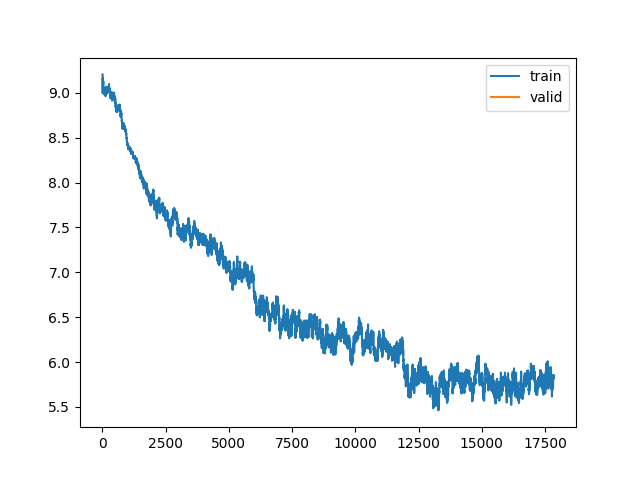

In [15]:
learn.recorder.plot_loss()



In [18]:
file_list = pd.read_csv(dataset_path_train + 'test_mod.csv')

test_df = pd.DataFrame(file_list, columns=['image'])
test_df['path'] = test_df['image'].map(lambda x:str(dataset_path_test+'images/images/'+x))
test_df = test_df.drop(columns=['image'])

test_df['class_id'] = [0]*len(test_df)

test_dl = dls.test_dl(test_df)
prediction, _ = learn.tta(dl=test_dl, n=3)


In [21]:
prediction.shape

torch.Size([31710, 4325])

In [22]:
# prediction_final = sum(prediction)

test_df['class_id'] = np.argmax(prediction, axis=1)

test_df[['path', 'class_id']].to_csv('submission.csv', index=False, sep='\t')

In [33]:
test_df.head()
test_df["image"] = test_df["path"].str.split("/").str[-1]
test_df.head()

,path,class_id,image
0,./images/images/mwiNS62kZXUEJARdf3rxCpI0VztLO1B7guKTDGMj.jpg,41,mwiNS62kZXUEJARdf3rxCpI0VztLO1B7guKTDGMj.jpg
1,./images/images/Dvtu5QLrVFq0JxjlcgmK94n3SC68iAphHXoBfzYM.jpg,823,Dvtu5QLrVFq0JxjlcgmK94n3SC68iAphHXoBfzYM.jpg
2,./images/images/mldYZ9OiXh5P0ERHNcKLp78SbMtfkBx2rwJeszoa.jpg,1879,mldYZ9OiXh5P0ERHNcKLp78SbMtfkBx2rwJeszoa.jpg
3,./images/images/tZaCF4XK2hPLTlW8YRdAnMD5mfSxzBujwVpUJ7b0.jpg,1287,tZaCF4XK2hPLTlW8YRdAnMD5mfSxzBujwVpUJ7b0.jpg
4,./images/images/73gEZNzIV9SLcf14wkrTYUoHJOMuDetsvihP0mAq.jpg,532,73gEZNzIV9SLcf14wkrTYUoHJOMuDetsvihP0mAq.jpg


In [47]:
orig_df = pd.read_csv(dataset_path_train + 'test.csv')
orig_df["class_id"] = orig_df['image'].map(test_df.set_index('image')['class_id'])
orig_df["class_id"] = orig_df["class_id"].fillna(0)
orig_df["class_id"] = orig_df["class_id"].astype("int64")
orig_df.head()

,class_id,image
0,41,mwiNS62kZXUEJARdf3rxCpI0VztLO1B7guKTDGMj.jpg
1,823,Dvtu5QLrVFq0JxjlcgmK94n3SC68iAphHXoBfzYM.jpg
2,1879,mldYZ9OiXh5P0ERHNcKLp78SbMtfkBx2rwJeszoa.jpg
3,1287,tZaCF4XK2hPLTlW8YRdAnMD5mfSxzBujwVpUJ7b0.jpg
4,532,73gEZNzIV9SLcf14wkrTYUoHJOMuDetsvihP0mAq.jpg


In [48]:
orig_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31718 entries, 0 to 31717
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   class_id  31718 non-null  int64 
 1   image     31718 non-null  object
dtypes: int64(1), object(1)
memory usage: 495.7+ KB


In [51]:
orig_df.to_csv("test_my.csv",index=False)

In [ ]:
prediction_blend = []

# for model in TIMM_MODELS:
model = TIMM_MODELS
prediction = train_and_predict(model)

model_weight = model[2]

prediction_blend.append(model_weight*prediction)

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

In [ ]:
prediction_final = sum(prediction_blend)

test_df['class_id'] = np.argmax(prediction_final, axis=1)

test_df[['image_name', 'class_id']].to_csv('submission.csv', index=False, sep='\t')

1677557442.0 03b8LYVsuXgeyoShqITkMWF4PjvUKJOrwldnfQtA.jpg


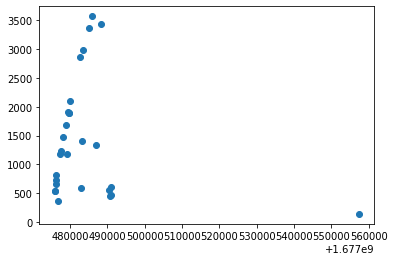

In [35]:
import os
import platform
import pandas as pd
def creation_date(path_to_file):
    """
    Try to get the date that a file was created, falling back to when it was
    last modified if that isn't possible.
    See http://stackoverflow.com/a/39501288/1709587 for explanation.
    """
    if platform.system() == 'Windows':
        return os.path.getctime(path_to_file)
    else:
        stat = os.stat(path_to_file)
        try:
            return stat.st_birthtime
        except AttributeError:
            # We're probably on Linux. No easy way to get creation dates here,
            # so we'll settle for when its content was last modified.
            return stat.st_mtime

def get_class_id(path, df): 
    return df[df['image']==path]['class_id']

df_classes = pd.read_csv("train.csv")
import glob
import matplotlib.pyplot as plt
i = 0
x = []
y = []
for file in glob.glob("./images/images/*.jpg"):
    image = file.split("\\")[-1]
    class_number = get_class_id(image, df_classes)
    if len(class_number) > 0:
        class_number = class_number.values[0]
    else:
        continue
    cr_date = creation_date("./images/images/" + image) # 0
    x.append(cr_date)
    y.append(class_number)
    if cr_date > 1677548262.0:
        print(cr_date,image)
        break
    # print(cr_date, class_number)
    i+=1
plt.scatter(x, y)

# print(creation_date("./images/images/vediWE6cXt1ayjU7gNYp4TxKR5F09QsDSqr8GmhL.jpg")) # 0 
# print(creation_date("./images/images/MTI84YVHwc1KUWdu7LqzEFZmkGJb9ofQxvCAeO5D.jpg")) # 100
# print(creation_date("./images/images/IQvZWKslpkqPgFOacdw6y9VT3S1moMu45zL7eChH.jpg")) # 500
# print(creation_date("./images/images/RU4SPDwouXM8QJbLd7AfIvH2VWleN3hpq0YEtjzO.jpg")) # 500
# print(creation_date("./images/images/sqym3bgzLoDWnHI67EJURTG2iulXptfakS4cKVBh.jpg")) # 500


In [20]:
ab.values[0]

1000